<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/gclb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [2]:
from google.colab import drive
drive.mount('./DRIVE', force_remount=True)

Mounted at ./DRIVE


In [0]:
!rm -rf sample_data

In [0]:
!rm -rf inputs/plates

In [5]:
import shutil, os
shutil.copytree('./DRIVE/My Drive/Colab Notebooks/input/plates', 'inputs/plates')

'inputs/plates'

In [0]:
import cv2
def crop_image(img_path, dest_path):
    path, file = os.path.split(img_path)
    if not file.endswith('.jpg'):
        return
    
    img = cv2.imread(img_path)
    img_m = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_m = cv2.medianBlur(img_m, 5)

    circles = None
    dp = .1
    while dp < 10:
        circles = cv2.HoughCircles(img_m, cv2.HOUGH_GRADIENT, dp, 50)
        dp += .1
        if circles is not None and len(circles) >=3:
            break
    if circles is None:
        cv2.imwrite(dest_path, img)
        return 
      
    img_center = (round(img.shape[0]/2), round(img.shape[1]/2))
    img_center_tol = (round(img_center[0]/3), round(img_center[1]/3))
    img_med_size = round((img.shape[0] + img.shape[1])/6)
    circle_candidates = []
    for circle in circles[0]:
        if abs(circle[0] - img_center[0]) > img_center_tol[0] or abs(circle[1] - img_center[1]) > img_center_tol[1]:
            continue
        if circle[2] < img_med_size:
            continue
        circle_candidates.append(circle)
    
    if len(circle_candidates) > 2:
        max_circle = circle_candidates[0]
        for circle in circle_candidates[1:]:
            if circle[2] > max_circle[2]:
                max_circle = circle
        main_circle = max_circle
    elif len(circle_candidates) == 1:
        main_circle = circle_candidates[0]
    else:
        main_circle =  circles[0][0]

    if main_circle[0] + main_circle[2] > img.shape[0] or main_circle[1] + main_circle[2] > img.shape[1]:
        cv2.imwrite(dest_path, img)
        return 
    main_circle = np.uint16(np.around(main_circle))
    
    mask = np.zeros((img.shape[0],img.shape[1],3), np.uint8)
    cv2.circle(mask,(main_circle[0], main_circle[1]),main_circle[2],(1,1,1),-1,8,0)
    out = np.uint16(img)*np.uint16(mask)
    crop_center = main_circle[2] if main_circle[2] >= 112 else 112
    out = out[
          abs(np.int8(main_circle[1])-np.int8(crop_center)):main_circle[1]+crop_center, 
          abs(np.int8(main_circle[0])-np.int8(crop_center)):main_circle[0]+crop_center,
    ]
    
    cv2.imwrite(dest_path, out)

In [7]:
!rm -rf val && rm -rf train

#%%
import pandas as pd
import os
import torch, torch.nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torch import nn
from torchvision import transforms, models

data_root = 'inputs/plates/plates/'
#%%

import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val' # validation

class_names = ['cleaned', 'dirty']

# удобное копирование картинок по папкам
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        # if i % 100 != 0:
        dest_dir = os.path.join(train_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        # else:
            # dest_dir = os.path.join(val_dir, class_name)
            # shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

for class_name in class_names:
    source_dir = os.path.join(data_root, 'ext-test', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 25/25 [00:00<00:00, 2276.49it/s]


In [0]:

batch_size = 8

train_transforms = transforms.Compose([
    # аугментация
#     transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # нормализация викторов картинок под рез-нет
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # нормализация викторов картинок под рез-нет
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


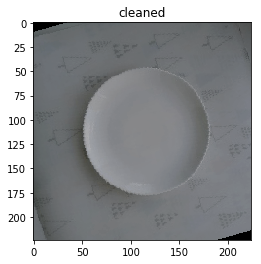

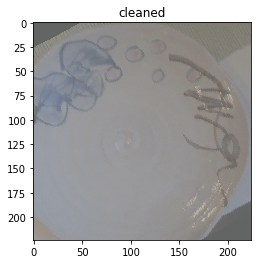

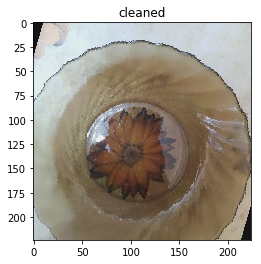

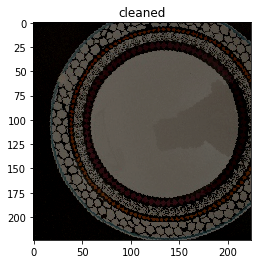

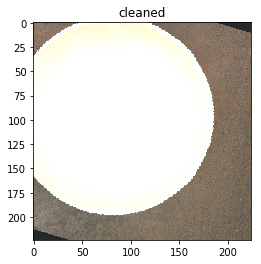

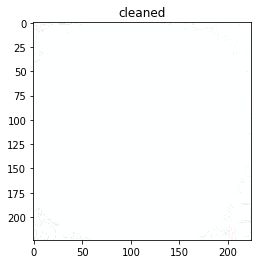

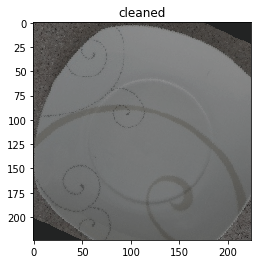

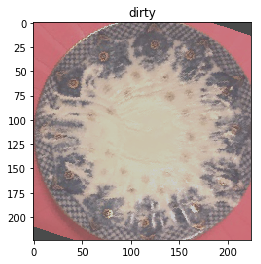

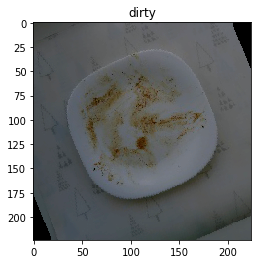

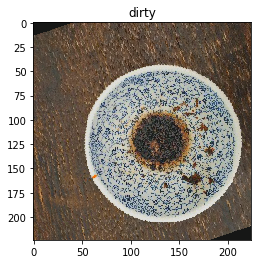

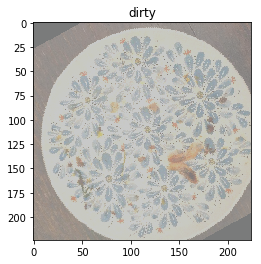

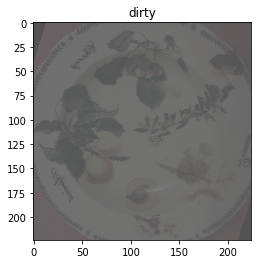

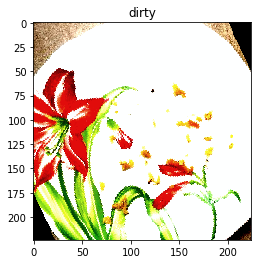

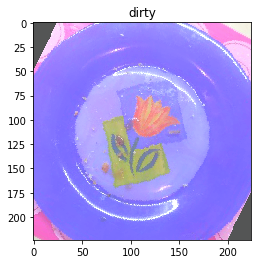

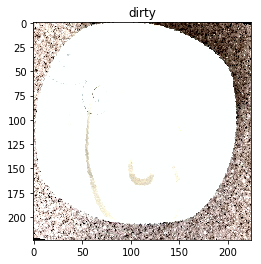

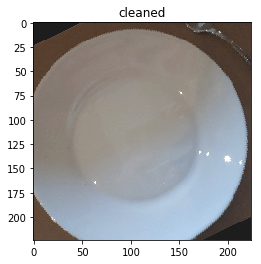

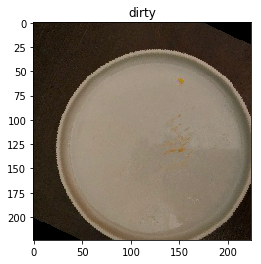

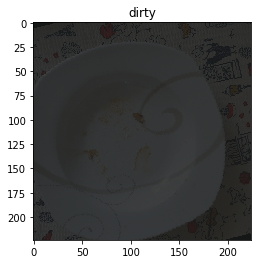

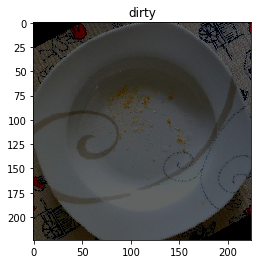

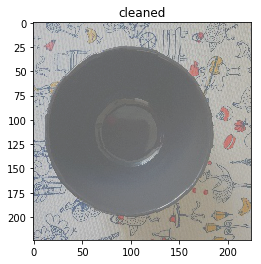

In [9]:
#%%

batch_size = 20
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
len(train_dataloader), len(train_dataloader)

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# денормализация векторов для печати
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

#%%

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [0]:
def make_resnext101_32x8d():
    model = models.resnext101_32x8d(pretrained=True)
    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),
        nn.Linear(model.fc.in_features, 100),
        nn.BatchNorm1d(100),
        nn.ELU(),
        nn.Linear(100, 2)
    )

    passed, muted = {}, {}
    for name, child in model.named_children():
        if name in ['layer4', 'avgpool', 'fc']:
            if name not in passed:
                passed[name] = 0
            for (i,param) in enumerate(child.parameters()):
                passed[name] += 1
        else:
            if name not in muted:
                muted[name] = 0
            for (i,param) in enumerate(child.parameters()):
                param.requires_grad = False         
                muted[name] += 1
    
    sum_muted, sum_passed = 0, 0
    for k, v in muted.items():
        sum_muted += v
    for k, v in passed.items():
        sum_passed += v
    
    print(muted, passed)
    print('total muted:', sum_muted, 'total passed:', sum_passed)
    return model

In [0]:
# pretrained=True сеть уже пред-тренерована на гугловом имадже-нете
def make_resnet152():
    model = models.resnet152(pretrained=True)
    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),
        nn.Linear(model.fc.in_features, 100),
        nn.BatchNorm1d(100),
        nn.ELU(),
        nn.Linear(100, 2)
    )
    
    passed, muted = {}, {}
    for name, child in model.named_children():
        if name in ['layer4', 'avgpool', 'fc']:
            if name not in passed:
                passed[name] = 0
            for (i,param) in enumerate(child.parameters()):
                passed[name] += 1
                
        elif name == 'layer3':
            for chName, chChild in child.named_children():
                if name not in muted:
                    muted[name] = 0
                if int(chName) not in [32, 33, 34, 35]:
                    for (i,param) in enumerate(chChild.parameters()):
                        param.requires_grad = False         
                        muted[name] += 1
                else:
                    if name not in passed:
                        passed[name] = 0
                    for (i,param) in enumerate(chChild.parameters()):       
                        passed[name] += 1
        else:
            if name not in muted:
                muted[name] = 0
            for (i,param) in enumerate(child.parameters()):
                param.requires_grad = False         
                muted[name] += 1
    
    sum_muted, sum_passed = 0, 0
    for k, v in muted.items():
        sum_muted += v
    for k, v in passed.items():
        sum_passed += v
    
    print(muted, passed)
    print('total muted:', sum_muted, 'total passed:', sum_passed)
    return model

In [0]:
# pretrained=True сеть уже пред-тренерована на гугловом имадже-нете
def make_resnet152():
    model = models.resnet152(pretrained=True)
    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),
        nn.Linear(model.fc.in_features, 100),
        nn.BatchNorm1d(100),
        nn.ELU(),
        nn.Linear(100, 2)
    )
    
    passed, muted = {}, {}
    for name, child in model.named_children():
        if name in ['layer4', 'avgpool', 'fc']:
            if name not in passed:
                passed[name] = 0
            for (i,param) in enumerate(child.parameters()):
                passed[name] += 1
                
        elif name == 'layer3':
            for chName, chChild in child.named_children():
                if name not in muted:
                    muted[name] = 0
                if int(chName) not in [32, 33, 34, 35]:
                    for (i,param) in enumerate(chChild.parameters()):
                        param.requires_grad = False         
                        muted[name] += 1
                else:
                    if name not in passed:
                        passed[name] = 0
                    for (i,param) in enumerate(chChild.parameters()):       
                        passed[name] += 1
        else:
            if name not in muted:
                muted[name] = 0
            for (i,param) in enumerate(child.parameters()):
                param.requires_grad = False         
                muted[name] += 1
    
    sum_muted, sum_passed = 0, 0
    for k, v in muted.items():
        sum_muted += v
    for k, v in passed.items():
        sum_passed += v
    
    print(muted, passed)
    print('total muted:', sum_muted, 'total passed:', sum_passed)
    return model

In [25]:
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
len(train_dataloader), len(train_dataloader)

class EpochModel():
    def __init__(self, train_dataloader, val_dataloader, model, loss, optimizer, scheduler, device):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        self.device = device
        
        self.train_ac_history = []
        self.val_ac_history = []
        
    def train(self, num_epochs, train_phases = ['train', 'val']):
        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
            # Each epoch has a training and validation phase
            for phase in train_phases:
                if phase == 'train':
                    self._epoch_run(self.train_dataloader, phase)
                else:
                    self._epoch_run(self.val_dataloader, phase)
        return model
    
    def _epoch_run(self, dataloader, phase):
        if phase == 'train':
#             self.scheduler.step()
            self.model.train()  # Set model to training mode
        else:
            self.model.eval()   # Set model to evaluate mode

        running_loss = 0.
        running_acc = 0.
 
        # Iterate over data.
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()

            # forward and backward
            with torch.set_grad_enabled(phase == 'train'):
                preds = self.model(inputs)
                loss_value = self.loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss_value.backward()
                    self.optimizer.step()
                  

            # statistics
            running_loss += loss_value.item()
            running_acc += (preds_class == labels.data).float().mean()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        if phase == 'train':
            self.scheduler.step(epoch_loss)
    
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
        if phase == "train":
            self.train_ac_history.append(epoch_acc.item())
        elif phase == "val":
            self.val_ac_history.append(epoch_acc.item())
            

tme_history = []
for i in [2]:
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(i)
    np.random.seed(i)
    torch.manual_seed(i)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = make_resnet152().to(device)

    for _ in [1]:
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adamax(model.parameters(), lr=.005)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

        tme = EpochModel(train_dataloader, val_dataloader, model, loss, optimizer, scheduler, device)
        tme_history.append(tme)
        tme.train(200)
    


{'conv1': 1, 'bn1': 2, 'relu': 0, 'maxpool': 0, 'layer1': 30, 'layer2': 75, 'layer3': 291} {'layer3': 36, 'layer4': 30, 'avgpool': 0, 'fc': 8}
total muted: 399 total passed: 74
Epoch 0/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.10it/s]

 40%|████      | 2/5 [00:01<00:02,  1.39it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.72it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.06it/s]

100%|██████████| 5/5 [00:01<00:00,  2.38it/s]



train Loss: 0.8989 Acc: 0.5750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.47it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.89it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.83it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]



val Loss: 203.0081 Acc: 0.5833
Epoch 1/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.26it/s]

 40%|████      | 2/5 [00:01<00:01,  1.58it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.92it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.25it/s]

100%|██████████| 5/5 [00:01<00:00,  2.56it/s]



train Loss: 0.6277 Acc: 0.7250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.75it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.20it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.69it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.16it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.59it/s]

100%|██████████| 6/6 [00:01<00:00,  4.25it/s]



val Loss: 424.6870 Acc: 0.4167
Epoch 2/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.30it/s]

 40%|████      | 2/5 [00:01<00:01,  1.63it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.95it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.28it/s]

100%|██████████| 5/5 [00:01<00:00,  2.59it/s]



train Loss: 0.5334 Acc: 0.7750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.47it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.89it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.36it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.84it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.95it/s]



val Loss: 9.3244 Acc: 0.4167
Epoch 3/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.32it/s]

 40%|████      | 2/5 [00:01<00:01,  1.65it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.32it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



train Loss: 0.5402 Acc: 0.8000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.55it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.97it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.40it/s]

100%|██████████| 6/6 [00:01<00:00,  4.05it/s]



val Loss: 0.7705 Acc: 0.6500
Epoch 4/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

 40%|████      | 2/5 [00:00<00:01,  1.88it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.20it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.52it/s]

100%|██████████| 5/5 [00:01<00:00,  2.80it/s]



train Loss: 0.3562 Acc: 0.9000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.49it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.92it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.38it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.85it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]



val Loss: 0.4931 Acc: 0.6667
Epoch 5/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.33it/s]

 40%|████      | 2/5 [00:01<00:01,  1.65it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



train Loss: 0.2807 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.51it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.93it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.41it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.89it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.35it/s]

100%|██████████| 6/6 [00:01<00:00,  4.00it/s]



val Loss: 0.4419 Acc: 0.7292
Epoch 6/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.32it/s]

 40%|████      | 2/5 [00:01<00:01,  1.64it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.29it/s]

100%|██████████| 5/5 [00:01<00:00,  2.59it/s]



train Loss: 0.2424 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.49it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.90it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.37it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.84it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.99it/s]



val Loss: 0.4844 Acc: 0.6667
Epoch 7/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.33it/s]

 40%|████      | 2/5 [00:01<00:01,  1.65it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.32it/s]

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]



train Loss: 0.1918 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.51it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.94it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.41it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.89it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.36it/s]

100%|██████████| 6/6 [00:01<00:00,  4.02it/s]



val Loss: 0.4539 Acc: 0.7917
Epoch 8/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.42it/s]

 40%|████      | 2/5 [00:00<00:01,  1.75it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.08it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.40it/s]

100%|██████████| 5/5 [00:01<00:00,  2.70it/s]



train Loss: 0.2271 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.49it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.90it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.38it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.85it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.34it/s]

100%|██████████| 6/6 [00:01<00:00,  4.00it/s]



val Loss: 0.3780 Acc: 0.8750
Epoch 9/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.37it/s]

 40%|████      | 2/5 [00:00<00:01,  1.70it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]



train Loss: 0.2293 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.45it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.86it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.33it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.82it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.95it/s]



val Loss: 0.3217 Acc: 0.8750
Epoch 10/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.28it/s]

 40%|████      | 2/5 [00:01<00:01,  1.60it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.94it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

100%|██████████| 5/5 [00:01<00:00,  2.58it/s]



train Loss: 0.1998 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.45it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.86it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.32it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.81it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.94it/s]



val Loss: 0.2588 Acc: 0.8750
Epoch 11/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.28it/s]

 40%|████      | 2/5 [00:01<00:01,  1.60it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.93it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.27it/s]

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]



train Loss: 0.1338 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.47it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.89it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.36it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.84it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.99it/s]



val Loss: 0.3252 Acc: 0.8750
Epoch 12/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

 40%|████      | 2/5 [00:01<00:01,  1.56it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.90it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.24it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]



train Loss: 0.2091 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.47it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.89it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.83it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.31it/s]

100%|██████████| 6/6 [00:01<00:00,  3.94it/s]



val Loss: 0.3802 Acc: 0.8333
Epoch 13/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.26it/s]

 40%|████      | 2/5 [00:01<00:01,  1.58it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.91it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.25it/s]

100%|██████████| 5/5 [00:01<00:00,  2.56it/s]



train Loss: 0.1891 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.52it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.94it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.40it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.86it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]



val Loss: 0.1761 Acc: 0.8958
Epoch 14/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.31it/s]

 40%|████      | 2/5 [00:01<00:01,  1.63it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.96it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.29it/s]

100%|██████████| 5/5 [00:01<00:00,  2.60it/s]



train Loss: 0.2308 Acc: 0.9000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.48it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.90it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.36it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.83it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.96it/s]



val Loss: 0.1510 Acc: 0.9583
Epoch 15/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

 40%|████      | 2/5 [00:01<00:01,  1.51it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]



train Loss: 0.0827 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.46it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.87it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.81it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.29it/s]

100%|██████████| 6/6 [00:01<00:00,  3.95it/s]



val Loss: 0.1739 Acc: 0.9583
Epoch 16/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

 40%|████      | 2/5 [00:01<00:01,  1.59it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.92it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]



train Loss: 0.1960 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.58it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.00it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.48it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.94it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  4.07it/s]



val Loss: 0.2056 Acc: 0.9375
Epoch 17/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

 40%|████      | 2/5 [00:01<00:01,  1.51it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]



train Loss: 0.0870 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.50it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.92it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.38it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.85it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]



val Loss: 0.2173 Acc: 0.9167
Epoch 18/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.32it/s]

 40%|████      | 2/5 [00:01<00:01,  1.64it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

100%|██████████| 5/5 [00:01<00:00,  2.61it/s]



train Loss: 0.1750 Acc: 0.8750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.46it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.88it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.79it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.96it/s]



val Loss: 0.2001 Acc: 0.9375
Epoch 19/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

 40%|████      | 2/5 [00:01<00:01,  1.55it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.89it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.22it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]



train Loss: 0.1081 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.49it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.91it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.38it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.86it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.93it/s]



val Loss: 0.2034 Acc: 0.9375
Epoch 20/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

 40%|████      | 2/5 [00:01<00:01,  1.59it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.91it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.25it/s]

100%|██████████| 5/5 [00:01<00:00,  2.55it/s]



train Loss: 0.0876 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.72it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.17it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.64it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  3.78it/s]



val Loss: 0.2014 Acc: 0.9167
Epoch 21/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.26it/s]

 40%|████      | 2/5 [00:01<00:01,  1.58it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.91it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.24it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]



train Loss: 0.1807 Acc: 0.9000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.76it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.21it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.69it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.18it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]



val Loss: 0.2052 Acc: 0.9375
Epoch 22/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

 40%|████      | 2/5 [00:01<00:01,  1.53it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]



train Loss: 0.0804 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.76it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.22it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.70it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.82it/s]



val Loss: 0.2548 Acc: 0.8750
Epoch 23/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

 40%|████      | 2/5 [00:01<00:01,  1.51it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]



train Loss: 0.0368 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.89it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.28it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.78it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.24it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.70it/s]

100%|██████████| 6/6 [00:01<00:00,  4.36it/s]



val Loss: 0.3115 Acc: 0.7708
Epoch 24/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.28it/s]

 40%|████      | 2/5 [00:01<00:01,  1.59it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.93it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

100%|██████████| 5/5 [00:01<00:00,  2.56it/s]



train Loss: 0.2093 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]



val Loss: 0.2780 Acc: 0.8333
Epoch 25/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]



train Loss: 0.1568 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]



val Loss: 0.2977 Acc: 0.8125
Epoch 26/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

 40%|████      | 2/5 [00:01<00:01,  1.54it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.87it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]



train Loss: 0.0309 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.62it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.77it/s]



val Loss: 0.2980 Acc: 0.8750
Epoch 27/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

 40%|████      | 2/5 [00:01<00:01,  1.52it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]



train Loss: 0.0626 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.71it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.17it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.64it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  3.78it/s]



val Loss: 0.2850 Acc: 0.8750
Epoch 28/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

 40%|████      | 2/5 [00:01<00:02,  1.48it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

100%|██████████| 5/5 [00:01<00:00,  2.47it/s]



train Loss: 0.2081 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.71it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]



val Loss: 0.3444 Acc: 0.8333
Epoch 29/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0971 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.73it/s]



val Loss: 0.3369 Acc: 0.8125
Epoch 30/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

 40%|████      | 2/5 [00:01<00:01,  1.56it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.89it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.21it/s]

100%|██████████| 5/5 [00:01<00:00,  2.53it/s]



train Loss: 0.1506 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.09it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]



val Loss: 0.2988 Acc: 0.8542
Epoch 31/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.2041 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.09it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]



val Loss: 0.1778 Acc: 0.9375
Epoch 32/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.39it/s]

 40%|████      | 2/5 [00:00<00:01,  1.71it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.05it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.37it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



train Loss: 0.0662 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.29it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.68it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]



val Loss: 0.1700 Acc: 0.9375
Epoch 33/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0330 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.72it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.17it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.64it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  3.78it/s]



val Loss: 0.2301 Acc: 0.8833
Epoch 34/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.12it/s]

 40%|████      | 2/5 [00:01<00:02,  1.42it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.07it/s]

100%|██████████| 5/5 [00:01<00:00,  2.40it/s]



train Loss: 0.1487 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.71it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.16it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]



val Loss: 0.3032 Acc: 0.8167
Epoch 35/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

 40%|████      | 2/5 [00:01<00:02,  1.49it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

100%|██████████| 5/5 [00:01<00:00,  2.47it/s]



train Loss: 0.0232 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.97it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.93it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.40it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]



val Loss: 0.2868 Acc: 0.8167
Epoch 36/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

 40%|████      | 2/5 [00:01<00:01,  1.58it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.92it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]



train Loss: 0.1109 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.47it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.88it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.35it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.81it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.91it/s]



val Loss: 0.2084 Acc: 0.9375
Epoch 37/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]



train Loss: 0.0711 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.72it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.17it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.64it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.77it/s]



val Loss: 0.1892 Acc: 0.9583
Epoch 38/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

 40%|████      | 2/5 [00:01<00:02,  1.50it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.16it/s]

100%|██████████| 5/5 [00:01<00:00,  2.48it/s]



train Loss: 0.1929 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.23it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.72it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.18it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

100%|██████████| 6/6 [00:01<00:00,  4.31it/s]



val Loss: 0.1949 Acc: 0.9375
Epoch 39/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

 40%|████      | 2/5 [00:01<00:01,  1.66it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.32it/s]

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]



train Loss: 0.0443 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.2007 Acc: 0.9167
Epoch 40/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.1443 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]



val Loss: 0.2042 Acc: 0.9375
Epoch 41/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0986 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1839 Acc: 0.9583
Epoch 42/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0262 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:04,  1.24it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.62it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.05it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.52it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.99it/s]

100%|██████████| 6/6 [00:01<00:00,  3.62it/s]



val Loss: 0.1669 Acc: 0.9583
Epoch 43/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

 40%|████      | 2/5 [00:01<00:02,  1.48it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

100%|██████████| 5/5 [00:01<00:00,  2.47it/s]



train Loss: 0.0677 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.09it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]



val Loss: 0.1505 Acc: 0.9583
Epoch 44/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0128 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.77it/s]



val Loss: 0.1518 Acc: 0.9583
Epoch 45/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

 40%|████      | 2/5 [00:01<00:02,  1.49it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0216 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.02it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]



val Loss: 0.1516 Acc: 0.9583
Epoch 46/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.0258 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]



val Loss: 0.1422 Acc: 0.9583
Epoch 47/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.0228 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]



val Loss: 0.1657 Acc: 0.9583
Epoch 48/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0932 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.60it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.04it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.51it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.98it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.45it/s]

100%|██████████| 6/6 [00:01<00:00,  4.10it/s]



val Loss: 0.2032 Acc: 0.9167
Epoch 49/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.1454 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.55it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.69it/s]



val Loss: 0.2647 Acc: 0.9167
Epoch 50/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.2152 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.67it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]



val Loss: 0.3466 Acc: 0.8958
Epoch 51/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.40it/s]

 40%|████      | 2/5 [00:00<00:01,  1.73it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.06it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.39it/s]

100%|██████████| 5/5 [00:01<00:00,  2.70it/s]



train Loss: 0.1941 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.45it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.88it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.82it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]



val Loss: 0.3140 Acc: 0.8958
Epoch 52/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.47it/s]

 40%|████      | 2/5 [00:00<00:01,  1.80it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.14it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.46it/s]

100%|██████████| 5/5 [00:01<00:00,  2.74it/s]



train Loss: 0.0777 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.78it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.23it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.69it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.80it/s]



val Loss: 0.1993 Acc: 0.8958
Epoch 53/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

 40%|████      | 2/5 [00:01<00:01,  1.54it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.87it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.21it/s]

100%|██████████| 5/5 [00:01<00:00,  2.52it/s]



train Loss: 0.5211 Acc: 0.9000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.71it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.17it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]



val Loss: 0.2326 Acc: 0.9375
Epoch 54/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.48it/s]

 40%|████      | 2/5 [00:00<00:01,  1.80it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.12it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.44it/s]

100%|██████████| 5/5 [00:01<00:00,  2.74it/s]



train Loss: 0.0745 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.78it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.22it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.69it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.81it/s]



val Loss: 0.1577 Acc: 0.9583
Epoch 55/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.45it/s]

 40%|████      | 2/5 [00:00<00:01,  1.77it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.42it/s]

100%|██████████| 5/5 [00:01<00:00,  2.71it/s]



Epoch    55: reducing learning rate of group 0 to 5.0000e-04.
train Loss: 0.0390 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.48it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.90it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.37it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.85it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.31it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]



val Loss: 0.1142 Acc: 0.9792
Epoch 56/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]



train Loss: 0.0123 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.29it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.68it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]



val Loss: 0.1143 Acc: 0.9792
Epoch 57/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

 40%|████      | 2/5 [00:01<00:01,  1.53it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]



train Loss: 0.0466 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.09it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.69it/s]



val Loss: 0.1274 Acc: 0.9375
Epoch 58/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.0578 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.02it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]



val Loss: 0.1201 Acc: 0.9792
Epoch 59/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0306 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.41it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.81it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.26it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.74it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.21it/s]

100%|██████████| 6/6 [00:01<00:00,  3.86it/s]



val Loss: 0.1211 Acc: 0.9792
Epoch 60/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0472 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.68it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.07it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1243 Acc: 0.9375
Epoch 61/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0485 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.71it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.62it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.12it/s]

100%|██████████| 6/6 [00:01<00:00,  3.78it/s]



val Loss: 0.1285 Acc: 0.9583
Epoch 62/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0159 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.67it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1340 Acc: 0.9375
Epoch 63/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0140 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.48it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.88it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.35it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.83it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.95it/s]



val Loss: 0.1146 Acc: 0.9792
Epoch 64/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

 40%|████      | 2/5 [00:01<00:01,  1.51it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]



train Loss: 0.0170 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.73it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.18it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.64it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.12it/s]

100%|██████████| 6/6 [00:01<00:00,  3.77it/s]



val Loss: 0.1243 Acc: 0.9375
Epoch 65/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0275 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.73it/s]



val Loss: 0.1208 Acc: 0.9375
Epoch 66/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0223 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.80it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.25it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.73it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.20it/s]

100%|██████████| 6/6 [00:01<00:00,  3.85it/s]



val Loss: 0.1224 Acc: 0.9375
Epoch 67/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

 40%|████      | 2/5 [00:01<00:02,  1.48it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



Epoch    67: reducing learning rate of group 0 to 5.0000e-05.
train Loss: 0.1434 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.69it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.13it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.62it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.10it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.53it/s]

100%|██████████| 6/6 [00:01<00:00,  4.19it/s]



val Loss: 0.1219 Acc: 0.9375
Epoch 68/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.44it/s]

 40%|████      | 2/5 [00:00<00:01,  1.77it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.43it/s]

100%|██████████| 5/5 [00:01<00:00,  2.72it/s]



train Loss: 0.0564 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.50it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.93it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.41it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.90it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  4.03it/s]



val Loss: 0.1264 Acc: 0.9375
Epoch 69/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.57it/s]

 40%|████      | 2/5 [00:00<00:01,  1.90it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.23it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.54it/s]

100%|██████████| 5/5 [00:01<00:00,  2.81it/s]



train Loss: 0.0600 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.56it/s]

 33%|███▎      | 2/6 [00:00<00:02,  2.00it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.48it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.96it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  4.08it/s]



val Loss: 0.1225 Acc: 0.9375
Epoch 70/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

 40%|████      | 2/5 [00:00<00:01,  1.68it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.35it/s]

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]



train Loss: 0.0123 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.96it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.43it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.91it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  4.05it/s]



val Loss: 0.1187 Acc: 0.9375
Epoch 71/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

 40%|████      | 2/5 [00:00<00:01,  1.71it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.04it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



train Loss: 0.0821 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.52it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.95it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.43it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.91it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  4.04it/s]



val Loss: 0.1217 Acc: 0.9375
Epoch 72/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

 40%|████      | 2/5 [00:01<00:01,  1.67it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.01it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.34it/s]

100%|██████████| 5/5 [00:01<00:00,  2.64it/s]



train Loss: 0.0120 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.74it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.20it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.67it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.15it/s]

100%|██████████| 6/6 [00:01<00:00,  3.81it/s]



val Loss: 0.1107 Acc: 0.9583
Epoch 73/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]



train Loss: 0.0784 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.09it/s]

100%|██████████| 6/6 [00:01<00:00,  3.73it/s]



val Loss: 0.1086 Acc: 0.9583
Epoch 74/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

 40%|████      | 2/5 [00:01<00:01,  1.52it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]



train Loss: 0.0106 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.75it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.21it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.69it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.82it/s]



val Loss: 0.1206 Acc: 0.9375
Epoch 75/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.39it/s]

 40%|████      | 2/5 [00:00<00:01,  1.71it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]



train Loss: 0.1002 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.74it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.19it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.65it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.12it/s]

100%|██████████| 6/6 [00:01<00:00,  3.79it/s]



val Loss: 0.1231 Acc: 0.9375
Epoch 76/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]



train Loss: 0.0820 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1201 Acc: 0.9375
Epoch 77/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0247 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.76it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.22it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.69it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.82it/s]



val Loss: 0.1225 Acc: 0.9375
Epoch 78/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0695 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]



val Loss: 0.1331 Acc: 0.9375
Epoch 79/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.1704 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]



val Loss: 0.1150 Acc: 0.9583
Epoch 80/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

 40%|████      | 2/5 [00:01<00:02,  1.49it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0181 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.07it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.64it/s]



val Loss: 0.1162 Acc: 0.9583
Epoch 81/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.0293 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.41it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.81it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.27it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.75it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.22it/s]

100%|██████████| 6/6 [00:01<00:00,  3.87it/s]



val Loss: 0.1092 Acc: 0.9583
Epoch 82/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

 40%|████      | 2/5 [00:01<00:01,  1.54it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]



train Loss: 0.0244 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.71it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.75it/s]



val Loss: 0.1102 Acc: 0.9792
Epoch 83/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.2115 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.09it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1005 Acc: 0.9792
Epoch 84/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.29it/s]

 40%|████      | 2/5 [00:01<00:01,  1.60it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.93it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.27it/s]

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]



train Loss: 0.0285 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]



val Loss: 0.1044 Acc: 0.9792
Epoch 85/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



Epoch    85: reducing learning rate of group 0 to 5.0000e-06.
train Loss: 0.0932 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.64it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.09it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.56it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.04it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.52it/s]

100%|██████████| 6/6 [00:01<00:00,  4.19it/s]



val Loss: 0.1095 Acc: 0.9583
Epoch 86/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.0262 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.76it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.20it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.68it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.83it/s]



val Loss: 0.1173 Acc: 0.9375
Epoch 87/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.34it/s]

 40%|████      | 2/5 [00:01<00:01,  1.66it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



train Loss: 0.0354 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.57it/s]

 33%|███▎      | 2/6 [00:00<00:02,  2.00it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.47it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.95it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.44it/s]

100%|██████████| 6/6 [00:01<00:00,  4.11it/s]



val Loss: 0.1213 Acc: 0.9375
Epoch 88/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

 40%|████      | 2/5 [00:00<00:01,  1.71it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.04it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.37it/s]

100%|██████████| 5/5 [00:01<00:00,  2.68it/s]



train Loss: 0.0280 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.51it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.94it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.41it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.90it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  4.03it/s]



val Loss: 0.1196 Acc: 0.9375
Epoch 89/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.45it/s]

 40%|████      | 2/5 [00:00<00:01,  1.78it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.43it/s]

100%|██████████| 5/5 [00:01<00:00,  2.70it/s]



train Loss: 0.0544 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.22it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.72it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.18it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.62it/s]

100%|██████████| 6/6 [00:01<00:00,  4.27it/s]



val Loss: 0.1187 Acc: 0.9375
Epoch 90/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.45it/s]

 40%|████      | 2/5 [00:00<00:01,  1.78it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.43it/s]

100%|██████████| 5/5 [00:01<00:00,  2.74it/s]



train Loss: 0.1518 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.50it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.93it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.40it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.86it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]



val Loss: 0.1093 Acc: 0.9792
Epoch 91/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

 40%|████      | 2/5 [00:00<00:01,  1.71it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.05it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.38it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



train Loss: 0.0164 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.47it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.88it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.35it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.82it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.93it/s]



val Loss: 0.1095 Acc: 0.9583
Epoch 92/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

 40%|████      | 2/5 [00:01<00:01,  1.59it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.92it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.25it/s]

100%|██████████| 5/5 [00:01<00:00,  2.56it/s]



train Loss: 0.0778 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.79it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.24it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.72it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.20it/s]

100%|██████████| 6/6 [00:01<00:00,  3.85it/s]



val Loss: 0.1146 Acc: 0.9583
Epoch 93/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.1652 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.62it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]



val Loss: 0.1095 Acc: 0.9583
Epoch 94/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

 40%|████      | 2/5 [00:01<00:01,  1.51it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.17it/s]

100%|██████████| 5/5 [00:01<00:00,  2.48it/s]



train Loss: 0.0250 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.45it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.87it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.81it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]



val Loss: 0.1164 Acc: 0.9375
Epoch 95/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.1277 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.75it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.21it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.68it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]



val Loss: 0.1155 Acc: 0.9375
Epoch 96/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



Epoch    96: reducing learning rate of group 0 to 5.0000e-07.
train Loss: 0.0368 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.55it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.02it/s]

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]



val Loss: 0.1210 Acc: 0.9375
Epoch 97/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0783 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.52it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.93it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.40it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.87it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.34it/s]

100%|██████████| 6/6 [00:01<00:00,  4.00it/s]



val Loss: 0.1402 Acc: 0.9167
Epoch 98/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

 40%|████      | 2/5 [00:01<00:01,  1.52it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]



train Loss: 0.1501 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.57it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.97it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  4.03it/s]



val Loss: 0.1372 Acc: 0.9167
Epoch 99/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

 40%|████      | 2/5 [00:01<00:02,  1.48it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.1151 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.68it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.07it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]



val Loss: 0.1353 Acc: 0.9167
Epoch 100/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0784 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.09it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]



val Loss: 0.1165 Acc: 0.9375
Epoch 101/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.0643 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.67it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]



val Loss: 0.1166 Acc: 0.9583
Epoch 102/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

 40%|████      | 2/5 [00:01<00:02,  1.48it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

100%|██████████| 5/5 [00:01<00:00,  2.47it/s]



train Loss: 0.0545 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.74it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.18it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.65it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  3.77it/s]



val Loss: 0.1019 Acc: 0.9792
Epoch 103/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0144 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.07it/s]

100%|██████████| 6/6 [00:01<00:00,  3.71it/s]



val Loss: 0.1088 Acc: 0.9792
Epoch 104/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0348 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.55it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]



val Loss: 0.1156 Acc: 0.9583
Epoch 105/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.1730 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.29it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.67it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.07it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1098 Acc: 0.9583
Epoch 106/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

 40%|████      | 2/5 [00:01<00:01,  1.55it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.88it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.22it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]



train Loss: 0.0091 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.59it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.03it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.51it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.99it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.47it/s]

100%|██████████| 6/6 [00:01<00:00,  4.13it/s]



val Loss: 0.1159 Acc: 0.9375
Epoch 107/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

 40%|████      | 2/5 [00:01<00:01,  1.69it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.35it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



train Loss: 0.0148 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.74it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.18it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.68it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.15it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.59it/s]

100%|██████████| 6/6 [00:01<00:00,  4.24it/s]



val Loss: 0.1213 Acc: 0.9583
Epoch 108/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

 40%|████      | 2/5 [00:01<00:01,  1.68it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.34it/s]

100%|██████████| 5/5 [00:01<00:00,  2.65it/s]



train Loss: 0.0209 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.56it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.00it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.47it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.94it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  4.08it/s]



val Loss: 0.1174 Acc: 0.9583
Epoch 109/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.43it/s]

 40%|████      | 2/5 [00:00<00:01,  1.76it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.09it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.41it/s]

100%|██████████| 5/5 [00:01<00:00,  2.70it/s]



train Loss: 0.0699 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.57it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.00it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.48it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.95it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  4.07it/s]



val Loss: 0.1210 Acc: 0.9583
Epoch 110/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.34it/s]

 40%|████      | 2/5 [00:01<00:01,  1.66it/s]

 60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.32it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



train Loss: 0.1711 Acc: 0.9000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.55it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.98it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.46it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.95it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.41it/s]

100%|██████████| 6/6 [00:01<00:00,  4.07it/s]



val Loss: 0.1084 Acc: 0.9792
Epoch 111/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.33it/s]

 40%|████      | 2/5 [00:01<00:01,  1.65it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.33it/s]

100%|██████████| 5/5 [00:01<00:00,  2.64it/s]



train Loss: 0.0134 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.56it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.99it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.47it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.95it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  4.08it/s]



val Loss: 0.1210 Acc: 0.9583
Epoch 112/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.33it/s]

 40%|████      | 2/5 [00:01<00:01,  1.65it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



train Loss: 0.0748 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.49it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.91it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.38it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.86it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.33it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]



val Loss: 0.1226 Acc: 0.9375
Epoch 113/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.31it/s]

 40%|████      | 2/5 [00:01<00:01,  1.64it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.96it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.29it/s]

100%|██████████| 5/5 [00:01<00:00,  2.60it/s]



train Loss: 0.0181 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.45it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.88it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.82it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.29it/s]

100%|██████████| 6/6 [00:01<00:00,  3.94it/s]



val Loss: 0.1192 Acc: 0.9583
Epoch 114/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.32it/s]

 40%|████      | 2/5 [00:01<00:01,  1.64it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



train Loss: 0.0620 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.48it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.91it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.38it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.86it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.34it/s]

100%|██████████| 6/6 [00:01<00:00,  3.99it/s]



val Loss: 0.1274 Acc: 0.9375
Epoch 115/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.29it/s]

 40%|████      | 2/5 [00:01<00:01,  1.61it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.94it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.27it/s]

100%|██████████| 5/5 [00:01<00:00,  2.59it/s]



train Loss: 0.0272 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.81it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.19it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.68it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.17it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.62it/s]

100%|██████████| 6/6 [00:01<00:00,  4.27it/s]



val Loss: 0.1151 Acc: 0.9792
Epoch 116/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

 40%|████      | 2/5 [00:01<00:02,  1.49it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

100%|██████████| 5/5 [00:01<00:00,  2.47it/s]



train Loss: 0.0154 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.43it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.84it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.29it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.76it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.24it/s]

100%|██████████| 6/6 [00:01<00:00,  3.89it/s]



val Loss: 0.1115 Acc: 0.9792
Epoch 117/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

 40%|████      | 2/5 [00:01<00:01,  1.51it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]



Epoch   117: reducing learning rate of group 0 to 5.0000e-08.
train Loss: 0.0311 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.74it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.19it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.66it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.14it/s]

100%|██████████| 6/6 [00:01<00:00,  3.79it/s]



val Loss: 0.1139 Acc: 0.9792
Epoch 118/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.30it/s]

 40%|████      | 2/5 [00:01<00:01,  1.63it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.96it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.28it/s]

100%|██████████| 5/5 [00:01<00:00,  2.59it/s]



train Loss: 0.1802 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1086 Acc: 0.9583
Epoch 119/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.0171 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.62it/s]



val Loss: 0.1101 Acc: 0.9792
Epoch 120/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

 40%|████      | 2/5 [00:01<00:01,  1.52it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]



train Loss: 0.0336 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]



val Loss: 0.1094 Acc: 0.9583
Epoch 121/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0294 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.07it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]



val Loss: 0.1203 Acc: 0.9375
Epoch 122/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

 40%|████      | 2/5 [00:01<00:02,  1.48it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]



train Loss: 0.0119 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.69it/s]



val Loss: 0.1109 Acc: 0.9792
Epoch 123/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0241 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.07it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1066 Acc: 0.9583
Epoch 124/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.40it/s]



train Loss: 0.0165 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:04,  1.25it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.62it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.05it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.53it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.65it/s]



val Loss: 0.1150 Acc: 0.9583
Epoch 125/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.29it/s]

 40%|████      | 2/5 [00:01<00:01,  1.61it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.93it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

100%|██████████| 5/5 [00:01<00:00,  2.56it/s]



train Loss: 0.0198 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.55it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]



val Loss: 0.1182 Acc: 0.9583
Epoch 126/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

 40%|████      | 2/5 [00:01<00:01,  1.51it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.83it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.16it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]



train Loss: 0.0124 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]



val Loss: 0.1145 Acc: 0.9583
Epoch 127/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.12it/s]

 40%|████      | 2/5 [00:01<00:02,  1.42it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.74it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0394 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.67it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.71it/s]



val Loss: 0.1158 Acc: 0.9375
Epoch 128/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.12it/s]

 40%|████      | 2/5 [00:01<00:02,  1.42it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.74it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.07it/s]

100%|██████████| 5/5 [00:01<00:00,  2.40it/s]



Epoch   128: reducing learning rate of group 0 to 5.0000e-09.
train Loss: 0.0158 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.75it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.20it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.67it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]



val Loss: 0.1210 Acc: 0.9375
Epoch 129/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.1371 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.64it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.07it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.56it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.03it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.50it/s]

100%|██████████| 6/6 [00:01<00:00,  4.16it/s]



val Loss: 0.1197 Acc: 0.9375
Epoch 130/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.40it/s]

 40%|████      | 2/5 [00:00<00:01,  1.73it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.07it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.39it/s]

100%|██████████| 5/5 [00:01<00:00,  2.69it/s]



train Loss: 0.0379 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.70it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.14it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.63it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.10it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.57it/s]

100%|██████████| 6/6 [00:01<00:00,  4.23it/s]



val Loss: 0.1226 Acc: 0.9375
Epoch 131/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.42it/s]

 40%|████      | 2/5 [00:00<00:01,  1.75it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.08it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.41it/s]

100%|██████████| 5/5 [00:01<00:00,  2.70it/s]



train Loss: 0.0299 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.97it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]



val Loss: 0.1282 Acc: 0.9375
Epoch 132/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

 40%|████      | 2/5 [00:00<00:01,  1.70it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.04it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]



train Loss: 0.0445 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.45it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.87it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.33it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.80it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.95it/s]



val Loss: 0.1345 Acc: 0.9167
Epoch 133/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.34it/s]

 40%|████      | 2/5 [00:01<00:01,  1.67it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.00it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.33it/s]

100%|██████████| 5/5 [00:01<00:00,  2.64it/s]



train Loss: 0.0134 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.56it/s]

 33%|███▎      | 2/6 [00:00<00:02,  2.00it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.47it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.96it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.43it/s]

100%|██████████| 6/6 [00:01<00:00,  4.09it/s]



val Loss: 0.1187 Acc: 0.9375
Epoch 134/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

 40%|████      | 2/5 [00:01<00:01,  1.68it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.34it/s]

100%|██████████| 5/5 [00:01<00:00,  2.64it/s]



train Loss: 0.0287 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.57it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.01it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.48it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.96it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.44it/s]

100%|██████████| 6/6 [00:01<00:00,  4.10it/s]



val Loss: 0.1129 Acc: 0.9375
Epoch 135/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.34it/s]

 40%|████      | 2/5 [00:01<00:01,  1.66it/s]

 60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.33it/s]

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]



train Loss: 0.4968 Acc: 0.9000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.96it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.91it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  4.03it/s]



val Loss: 0.1054 Acc: 0.9792
Epoch 136/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

 40%|████      | 2/5 [00:00<00:01,  1.69it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.35it/s]

100%|██████████| 5/5 [00:01<00:00,  2.65it/s]



train Loss: 0.0114 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.46it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.89it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.35it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.83it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.31it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]



val Loss: 0.1061 Acc: 0.9792
Epoch 137/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

 40%|████      | 2/5 [00:00<00:01,  1.68it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.35it/s]

100%|██████████| 5/5 [00:01<00:00,  2.64it/s]



train Loss: 0.0783 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.53it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.96it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.91it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  4.04it/s]



val Loss: 0.1122 Acc: 0.9583
Epoch 138/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.34it/s]

 40%|████      | 2/5 [00:01<00:01,  1.66it/s]

 60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.32it/s]

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]



train Loss: 0.1170 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.88it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.25it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.74it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.23it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.66it/s]

100%|██████████| 6/6 [00:01<00:00,  4.31it/s]



val Loss: 0.1134 Acc: 0.9583
Epoch 139/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

 40%|████      | 2/5 [00:01<00:01,  1.53it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

100%|██████████| 5/5 [00:01<00:00,  2.52it/s]



train Loss: 0.0526 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.09it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]



val Loss: 0.1129 Acc: 0.9583
Epoch 140/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

 40%|████      | 2/5 [00:01<00:01,  1.54it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]



train Loss: 0.0513 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.76it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.20it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.67it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.15it/s]

100%|██████████| 6/6 [00:01<00:00,  3.79it/s]



val Loss: 0.1274 Acc: 0.9375
Epoch 141/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.31it/s]

 40%|████      | 2/5 [00:01<00:01,  1.63it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.96it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.29it/s]

100%|██████████| 5/5 [00:01<00:00,  2.61it/s]



train Loss: 0.0121 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.09it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1183 Acc: 0.9792
Epoch 142/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

 40%|████      | 2/5 [00:01<00:01,  1.55it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.88it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

100%|██████████| 5/5 [00:01<00:00,  2.52it/s]



train Loss: 0.0703 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]



val Loss: 0.1169 Acc: 0.9583
Epoch 143/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0205 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.09it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]



val Loss: 0.1148 Acc: 0.9583
Epoch 144/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0231 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.09it/s]

100%|██████████| 6/6 [00:01<00:00,  3.76it/s]



val Loss: 0.1226 Acc: 0.9583
Epoch 145/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

 40%|████      | 2/5 [00:01<00:01,  1.53it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

100%|██████████| 5/5 [00:01<00:00,  2.49it/s]



train Loss: 0.0574 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.74it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.06it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.53it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.03it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.49it/s]

100%|██████████| 6/6 [00:01<00:00,  4.14it/s]



val Loss: 0.1198 Acc: 0.9583
Epoch 146/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.1257 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.55it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]



val Loss: 0.1504 Acc: 0.9167
Epoch 147/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0407 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]



val Loss: 0.1461 Acc: 0.9167
Epoch 148/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.1856 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1436 Acc: 0.9167
Epoch 149/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]



train Loss: 0.0790 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.07it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.65it/s]



val Loss: 0.1505 Acc: 0.9167
Epoch 150/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0135 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.07it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.53it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.00it/s]

100%|██████████| 6/6 [00:01<00:00,  3.64it/s]



val Loss: 0.1416 Acc: 0.9167
Epoch 151/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.12it/s]

 40%|████      | 2/5 [00:01<00:02,  1.42it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.1060 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:04,  1.25it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.63it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.06it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.53it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]



val Loss: 0.1343 Acc: 0.9375
Epoch 152/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

 40%|████      | 2/5 [00:01<00:01,  1.56it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.89it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.23it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]



train Loss: 0.0136 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.50it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.91it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.37it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.86it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.34it/s]

100%|██████████| 6/6 [00:01<00:00,  4.00it/s]



val Loss: 0.1248 Acc: 0.9375
Epoch 153/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.56it/s]

 40%|████      | 2/5 [00:00<00:01,  1.90it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.22it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.54it/s]

100%|██████████| 5/5 [00:01<00:00,  2.82it/s]



train Loss: 0.0726 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.53it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.96it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.43it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.91it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.36it/s]

100%|██████████| 6/6 [00:01<00:00,  4.02it/s]



val Loss: 0.1149 Acc: 0.9583
Epoch 154/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.41it/s]

 40%|████      | 2/5 [00:00<00:01,  1.73it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.07it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.38it/s]

100%|██████████| 5/5 [00:01<00:00,  2.68it/s]



train Loss: 0.0326 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.52it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.95it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.42it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.90it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.37it/s]

100%|██████████| 6/6 [00:01<00:00,  4.02it/s]



val Loss: 0.1184 Acc: 0.9583
Epoch 155/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

 40%|████      | 2/5 [00:01<00:01,  1.68it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.01it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.35it/s]

100%|██████████| 5/5 [00:01<00:00,  2.65it/s]



train Loss: 0.1046 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.97it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.43it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  4.01it/s]



val Loss: 0.1187 Acc: 0.9583
Epoch 156/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

 40%|████      | 2/5 [00:01<00:01,  1.68it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.34it/s]

100%|██████████| 5/5 [00:01<00:00,  2.65it/s]



train Loss: 0.0384 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.47it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.88it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.36it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.84it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.98it/s]



val Loss: 0.1261 Acc: 0.9375
Epoch 157/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.31it/s]

 40%|████      | 2/5 [00:01<00:01,  1.63it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

100%|██████████| 5/5 [00:01<00:00,  2.61it/s]



train Loss: 0.1148 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.59it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.02it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.49it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.96it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.44it/s]

100%|██████████| 6/6 [00:01<00:00,  4.09it/s]



val Loss: 0.1257 Acc: 0.9375
Epoch 158/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.37it/s]

 40%|████      | 2/5 [00:00<00:01,  1.70it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

100%|██████████| 5/5 [00:01<00:00,  2.65it/s]



train Loss: 0.0742 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.97it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.43it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.91it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]



val Loss: 0.1127 Acc: 0.9375
Epoch 159/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.31it/s]

 40%|████      | 2/5 [00:01<00:01,  1.63it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



train Loss: 0.0125 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.49it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.92it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.38it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.87it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.33it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]



val Loss: 0.1257 Acc: 0.9375
Epoch 160/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.32it/s]

 40%|████      | 2/5 [00:01<00:01,  1.64it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

100%|██████████| 5/5 [00:01<00:00,  2.60it/s]



train Loss: 0.0123 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.97it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  4.01it/s]



val Loss: 0.1233 Acc: 0.9375
Epoch 161/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.33it/s]

 40%|████      | 2/5 [00:01<00:01,  1.65it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.33it/s]

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]



train Loss: 0.0145 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.45it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.86it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.32it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.80it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.94it/s]



val Loss: 0.1100 Acc: 0.9583
Epoch 162/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

 40%|████      | 2/5 [00:01<00:01,  1.56it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.90it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.23it/s]

100%|██████████| 5/5 [00:01<00:00,  2.55it/s]



train Loss: 0.2149 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.75it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.20it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.68it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.80it/s]



val Loss: 0.1024 Acc: 0.9792
Epoch 163/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

 40%|████      | 2/5 [00:01<00:01,  1.52it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.18it/s]

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]



train Loss: 0.0126 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.71it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  3.75it/s]



val Loss: 0.1277 Acc: 0.9375
Epoch 164/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.33it/s]

 40%|████      | 2/5 [00:01<00:01,  1.65it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.31it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



train Loss: 0.1874 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.25it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.63it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.07it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.54it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]



val Loss: 0.1324 Acc: 0.9375
Epoch 165/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0508 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.65it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.55it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.02it/s]

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]



val Loss: 0.1285 Acc: 0.9375
Epoch 166/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0132 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.73it/s]



val Loss: 0.1256 Acc: 0.9375
Epoch 167/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.11it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0205 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1179 Acc: 0.9583
Epoch 168/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.40it/s]



train Loss: 0.0121 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.40it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.79it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.24it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.71it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.18it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]



val Loss: 0.1101 Acc: 0.9792
Epoch 169/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.0139 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.79it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.24it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.70it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.81it/s]



val Loss: 0.1060 Acc: 0.9792
Epoch 170/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0947 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.59it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.98it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  4.05it/s]



val Loss: 0.1021 Acc: 0.9792
Epoch 171/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]



train Loss: 0.0256 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.67it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.71it/s]



val Loss: 0.1045 Acc: 0.9792
Epoch 172/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.12it/s]

 40%|████      | 2/5 [00:01<00:02,  1.42it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0855 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:04,  1.25it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.63it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.06it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.53it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.64it/s]



val Loss: 0.1157 Acc: 0.9375
Epoch 173/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.12it/s]

 40%|████      | 2/5 [00:01<00:02,  1.42it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.74it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

100%|██████████| 5/5 [00:01<00:00,  2.40it/s]



train Loss: 0.0113 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.26it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.09it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.55it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.68it/s]



val Loss: 0.1208 Acc: 0.9375
Epoch 174/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.46it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.44it/s]



train Loss: 0.0697 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.49it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.89it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.35it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.84it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.31it/s]

100%|██████████| 6/6 [00:01<00:00,  3.96it/s]



val Loss: 0.1273 Acc: 0.9375
Epoch 175/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0858 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.70it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.15it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.63it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.11it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.58it/s]

100%|██████████| 6/6 [00:01<00:00,  4.23it/s]



val Loss: 0.1322 Acc: 0.9167
Epoch 176/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.37it/s]

 40%|████      | 2/5 [00:00<00:01,  1.70it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.04it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.36it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



train Loss: 0.0734 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.50it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.93it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.40it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.88it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.36it/s]

100%|██████████| 6/6 [00:01<00:00,  4.02it/s]



val Loss: 0.1176 Acc: 0.9375
Epoch 177/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.44it/s]

 40%|████      | 2/5 [00:00<00:01,  1.77it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.12it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.44it/s]

100%|██████████| 5/5 [00:01<00:00,  2.72it/s]



train Loss: 0.0397 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.58it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.02it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.50it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.98it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.46it/s]

100%|██████████| 6/6 [00:01<00:00,  4.12it/s]



val Loss: 0.1202 Acc: 0.9375
Epoch 178/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.50it/s]

 40%|████      | 2/5 [00:00<00:01,  1.83it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.16it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.48it/s]

100%|██████████| 5/5 [00:01<00:00,  2.77it/s]



train Loss: 0.0150 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.97it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.44it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.94it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.41it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]



val Loss: 0.1159 Acc: 0.9583
Epoch 179/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

 40%|████      | 2/5 [00:01<00:01,  1.67it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.00it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.33it/s]

100%|██████████| 5/5 [00:01<00:00,  2.64it/s]



train Loss: 0.0290 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.44it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.86it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.33it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.81it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.93it/s]



val Loss: 0.1159 Acc: 0.9583
Epoch 180/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.32it/s]

 40%|████      | 2/5 [00:01<00:01,  1.64it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.32it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]



train Loss: 0.0317 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.51it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.94it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.41it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.89it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]



val Loss: 0.1217 Acc: 0.9583
Epoch 181/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

 40%|████      | 2/5 [00:00<00:01,  1.71it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.04it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.37it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



train Loss: 0.0573 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.50it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.92it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.39it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.86it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

100%|██████████| 6/6 [00:01<00:00,  3.97it/s]



val Loss: 0.1199 Acc: 0.9583
Epoch 182/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

 40%|████      | 2/5 [00:01<00:01,  1.68it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.01it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.33it/s]

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]



train Loss: 0.0303 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:02,  1.79it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.23it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.72it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.19it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

100%|██████████| 6/6 [00:01<00:00,  4.25it/s]



val Loss: 0.1193 Acc: 0.9583
Epoch 183/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.63it/s]

 40%|████      | 2/5 [00:00<00:01,  1.96it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.29it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  2.87it/s]



train Loss: 0.0381 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.42it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.83it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.30it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.78it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.27it/s]

100%|██████████| 6/6 [00:01<00:00,  3.93it/s]



val Loss: 0.1264 Acc: 0.9375
Epoch 184/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

 40%|████      | 2/5 [00:01<00:01,  1.58it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.93it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.26it/s]

100%|██████████| 5/5 [00:01<00:00,  2.58it/s]



train Loss: 0.0303 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.78it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.24it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.72it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.18it/s]

100%|██████████| 6/6 [00:01<00:00,  3.82it/s]



val Loss: 0.1194 Acc: 0.9375
Epoch 185/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

 40%|████      | 2/5 [00:01<00:02,  1.49it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.15it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0100 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.71it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.16it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.11it/s]

100%|██████████| 6/6 [00:01<00:00,  3.77it/s]



val Loss: 0.1204 Acc: 0.9375
Epoch 186/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.50it/s]

 40%|████      | 2/5 [00:00<00:01,  1.82it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.16it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.47it/s]

100%|██████████| 5/5 [00:01<00:00,  2.73it/s]



train Loss: 0.1519 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.70it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.15it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.62it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]



val Loss: 0.1143 Acc: 0.9792
Epoch 187/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.31it/s]

 40%|████      | 2/5 [00:01<00:01,  1.63it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.96it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.29it/s]

100%|██████████| 5/5 [00:01<00:00,  2.60it/s]



train Loss: 0.0221 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1163 Acc: 0.9583
Epoch 188/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.46it/s]

 40%|████      | 2/5 [00:00<00:01,  1.77it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.10it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.42it/s]

100%|██████████| 5/5 [00:01<00:00,  2.71it/s]



train Loss: 0.1133 Acc: 0.9500




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.14it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]



val Loss: 0.1050 Acc: 0.9792
Epoch 189/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

 40%|████      | 2/5 [00:01<00:01,  1.54it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]



train Loss: 0.0130 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.40it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.80it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.25it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.72it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.18it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]



val Loss: 0.1096 Acc: 0.9792
Epoch 190/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.45it/s]



train Loss: 0.1581 Acc: 0.9750




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:04,  1.23it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.61it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.04it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.50it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.98it/s]

100%|██████████| 6/6 [00:01<00:00,  3.64it/s]



val Loss: 0.1080 Acc: 0.9792
Epoch 191/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

 40%|████      | 2/5 [00:01<00:02,  1.47it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0253 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.67it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.58it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1132 Acc: 0.9583
Epoch 192/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.42it/s]



train Loss: 0.0329 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.66it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.57it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.05it/s]

100%|██████████| 6/6 [00:01<00:00,  3.70it/s]



val Loss: 0.1150 Acc: 0.9583
Epoch 193/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.10it/s]

 40%|████      | 2/5 [00:01<00:02,  1.40it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.06it/s]

100%|██████████| 5/5 [00:01<00:00,  2.39it/s]



train Loss: 0.0570 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.07it/s]

100%|██████████| 6/6 [00:01<00:00,  3.73it/s]



val Loss: 0.1126 Acc: 0.9792
Epoch 194/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0225 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.29it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.68it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]



val Loss: 0.1151 Acc: 0.9583
Epoch 195/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.18it/s]

 40%|████      | 2/5 [00:01<00:02,  1.48it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.14it/s]

100%|██████████| 5/5 [00:01<00:00,  2.46it/s]



train Loss: 0.0246 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.68it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.72it/s]



val Loss: 0.1110 Acc: 0.9792
Epoch 196/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0429 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.64it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.55it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.69it/s]



val Loss: 0.1353 Acc: 0.9375
Epoch 197/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

 40%|████      | 2/5 [00:01<00:02,  1.43it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

100%|██████████| 5/5 [00:01<00:00,  2.41it/s]



train Loss: 0.0108 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.80it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.25it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.73it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.16it/s]

100%|██████████| 6/6 [00:01<00:00,  3.81it/s]



val Loss: 0.1254 Acc: 0.9375
Epoch 198/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

 40%|████      | 2/5 [00:01<00:02,  1.44it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.77it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.10it/s]

100%|██████████| 5/5 [00:01<00:00,  2.43it/s]



train Loss: 0.0102 Acc: 1.0000




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.57it/s]

 33%|███▎      | 2/6 [00:00<00:02,  2.00it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.48it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.97it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.44it/s]

100%|██████████| 6/6 [00:01<00:00,  4.10it/s]



val Loss: 0.1280 Acc: 0.9375
Epoch 199/199:




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.37it/s]

 40%|████      | 2/5 [00:00<00:01,  1.70it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.35it/s]

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]



train Loss: 0.4073 Acc: 0.9250




  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]

 33%|███▎      | 2/6 [00:00<00:02,  1.97it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.45it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  4.05it/s]



val Loss: 0.1143 Acc: 0.9375


5 0.9151250240206719


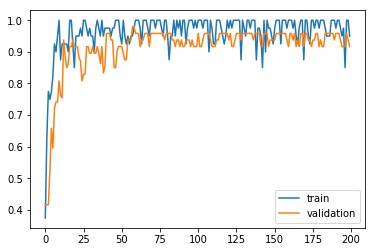

5 0.9267708525061608


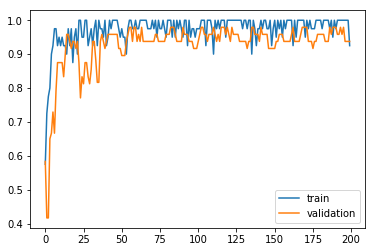

5 0.8091666877269745


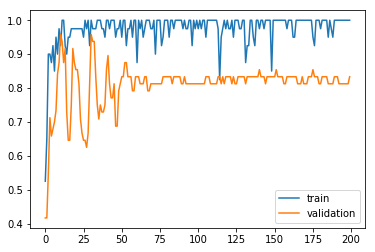

5 0.8246041882038116


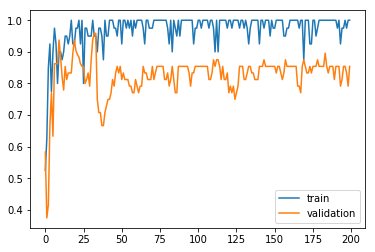

5 0.9247088076606873


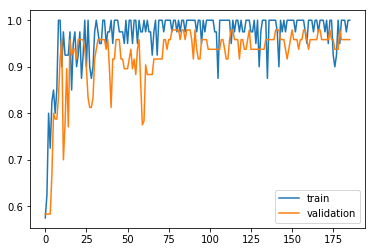

In [23]:
for th in tme_history:
    print(i, np.mean(th.val_ac_history))
    plt.plot(th.train_ac_history, label='train')
    plt.plot(th.val_ac_history, label='validation')
    plt.legend()
    plt.show()
    plt.pause(.001)
    

In [0]:
top_model = tme_history[0]
if len(tme_history) > 1:
    for tm in tme_history[1:]:
        if np.mean(tm.val_ac_history) > np.mean(top_model.val_ac_history):
            top_model = tm
model = top_model.model
    

rm: cannot remove 'submission.csv': No such file or directory






  0%|          | 0/15 [00:00<?, ?it/s]



  7%|▋         | 1/15 [00:02<00:37,  2.67s/it]



 13%|█▎        | 2/15 [00:03<00:28,  2.18s/it]



 20%|██        | 3/15 [00:04<00:21,  1.82s/it]



 27%|██▋       | 4/15 [00:05<00:17,  1.56s/it]



 33%|███▎      | 5/15 [00:06<00:13,  1.39s/it]



 40%|████      | 6/15 [00:07<00:11,  1.26s/it]



 47%|████▋     | 7/15 [00:08<00:09,  1.17s/it]



 53%|█████▎    | 8/15 [00:09<00:07,  1.12s/it]



 60%|██████    | 9/15 [00:10<00:06,  1.08s/it]



 67%|██████▋   | 10/15 [00:11<00:05,  1.04s/it]



 73%|███████▎  | 11/15 [00:12<00:04,  1.02s/it]



 80%|████████  | 12/15 [00:13<00:03,  1.01s/it]



 87%|████████▋ | 13/15 [00:14<00:01,  1.01it/s]



 93%|█████████▎| 14/15 [00:15<00:00,  1.02it/s]



100%|██████████| 15/15 [00:16<00:00,  1.05it/s]





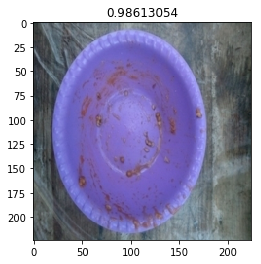

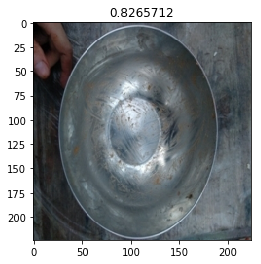

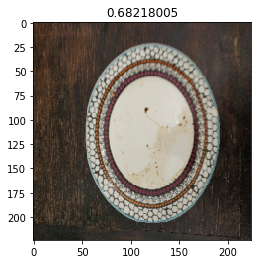

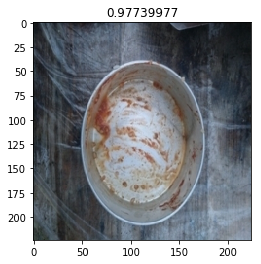

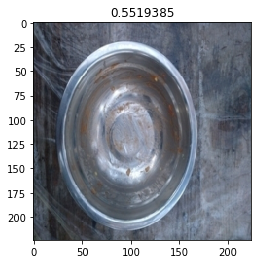

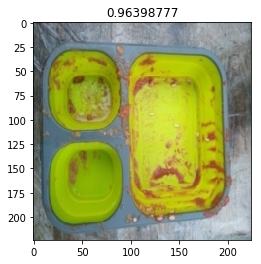

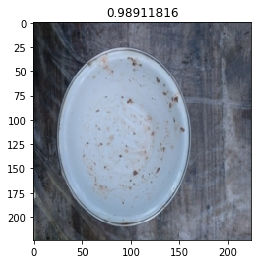

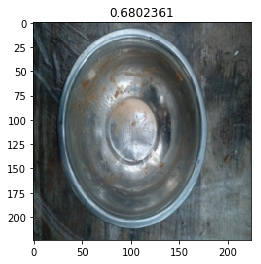

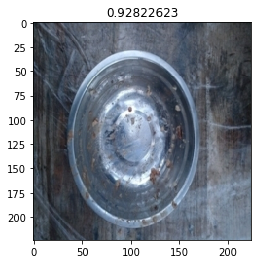

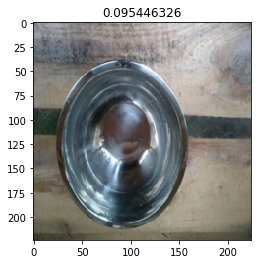

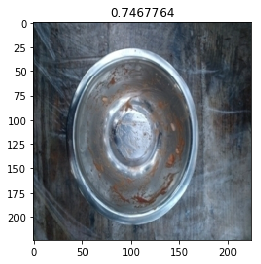

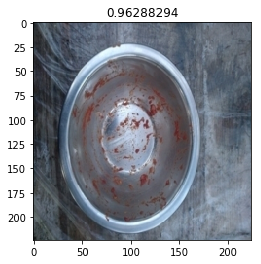

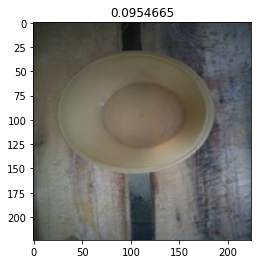

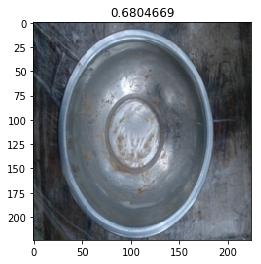

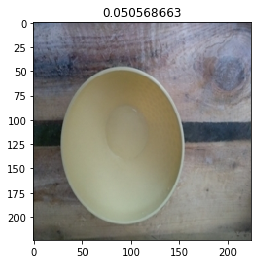

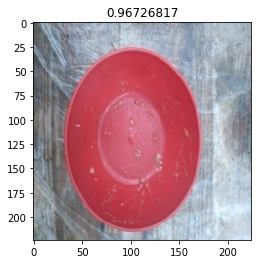

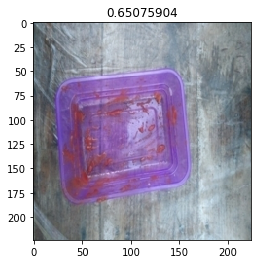

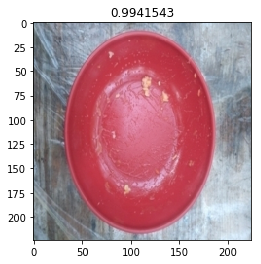

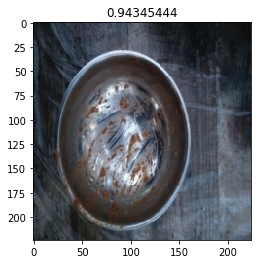

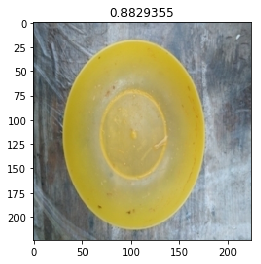

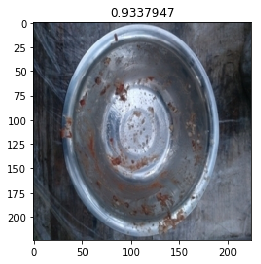

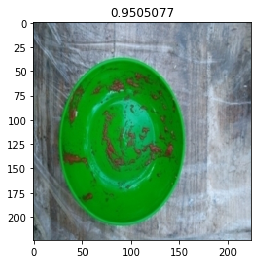

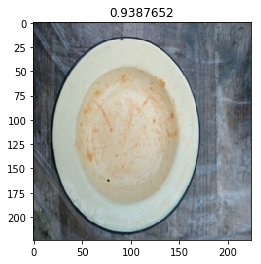

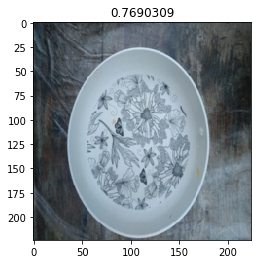

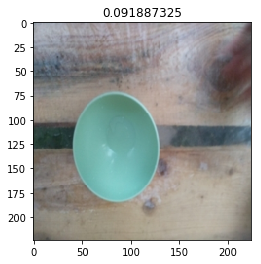

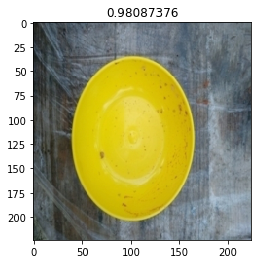

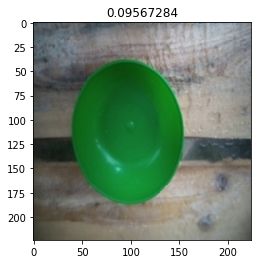

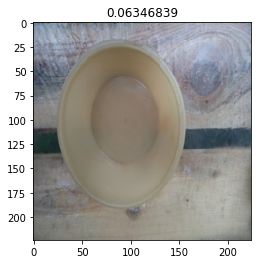

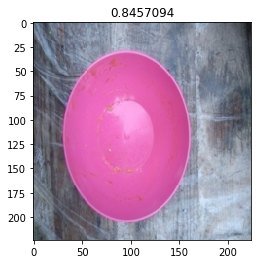

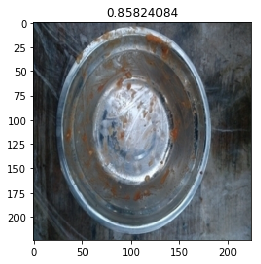

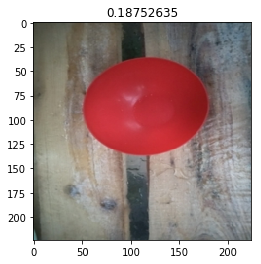

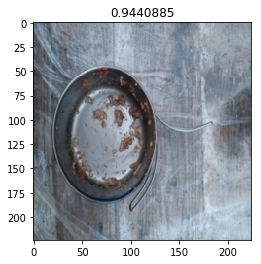

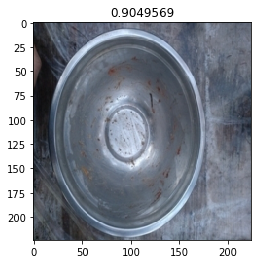

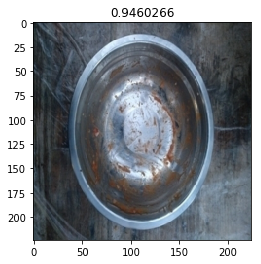

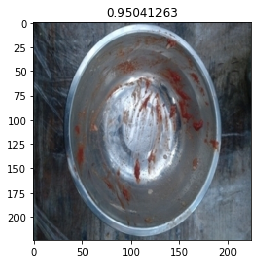

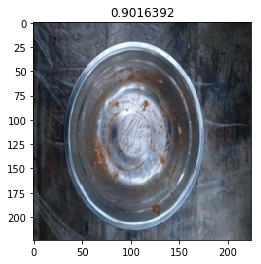

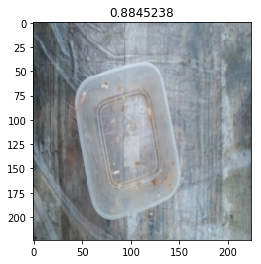

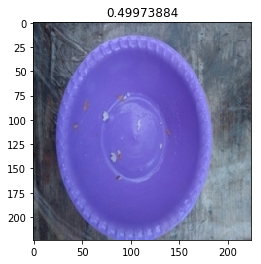

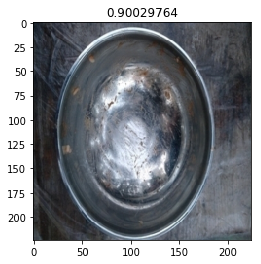

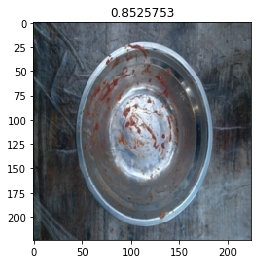

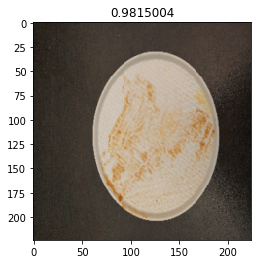

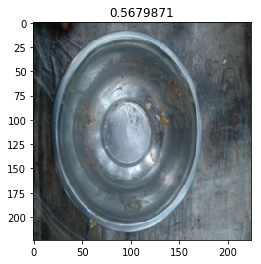

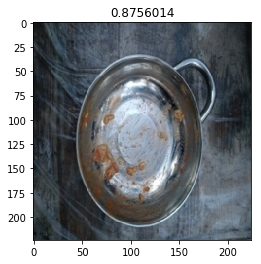

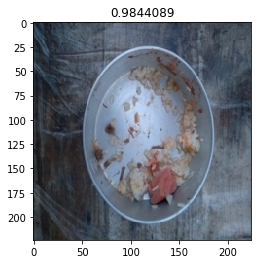

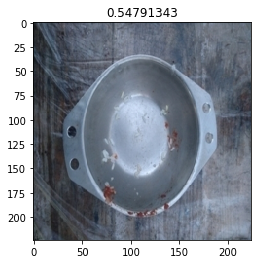

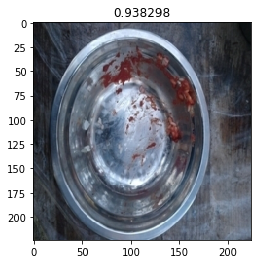

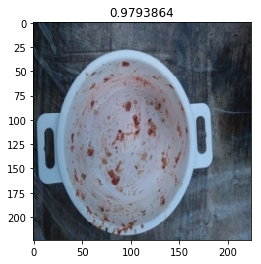

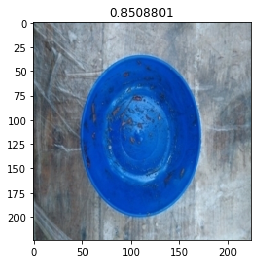

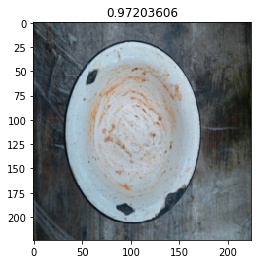

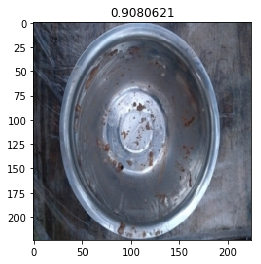

In [0]:
#%%

!rm -rf test
!rm submission.csv

test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=50, shuffle=False, num_workers=batch_size)

model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)
    
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

submission_df.to_csv('submission.csv')

In [0]:
!ls -la

total 48
drwxr-xr-x 1 root root 4096 Jul 28 21:47 .
drwxr-xr-x 1 root root 4096 Jul 28 20:18 ..
drwxr-xr-x 1 root root 4096 Jul 19 16:14 .config
drwx------ 3 root root 4096 Jul 28 20:57 DRIVE
drwxr-xr-x 3 root root 4096 Jul 28 20:57 inputs
drwxr-xr-x 1 root root 4096 Jul 19 16:14 sample_data
-rw-r--r-- 1 root root 8653 Jul 28 21:47 submission.csv
drwxr-xr-x 3 root root 4096 Jul 28 21:47 test
drwxr-xr-x 4 root root 4096 Jul 28 21:01 train
drwxr-xr-x 4 root root 4096 Jul 28 21:01 val
